# Задача 1: "Идеальная игра": какие комбинации жанров/тегов/фич повышают популярность и качество игры


## Смысл:
Задача направлена на поиск закономерностей между жанрами, тегами и ключевыми игровыми фичами, которые влияют на популярность и качество игры. Анализ позволит выделить успешные паттерны — например, связку определённых жанров с социальными функциями или сюжетными элементами, — и понять, какие комбинации повышают интерес аудитории, вовлечённость и рейтинг.

Под интересом понимаем:

*   **интерес аудитории**: ratings_count, reviews_count, suggestions_count, added

*   **качество**: взвешенная оценка weighted_rating


Результаты помогут сформировать ориентиры для создания игры с максимальным потенциалом успеха.


## Как мы решаем задачу:

Мы будем опираться на очищенный датасет с уже посчитанным столбцом weighted_rating, в нем рассмотрим:

* Популярность/интерес: ratings_count, added

* Качество: weighted_rating

* Игровые характеристики: жанры (main_genre, genre_count), теги (tags)

**Что хотим построить и зачем:**

* Диаграммы распределения популярности по жанрам и тегам, чтобы получить топ самых популярных жанров и тегов у игр

* Столбчатые диаграммы средних рейтингов по жанрам и тегам, чтобы выделить наиболее качественные категории

* Топ-10 комбинацй жанров/тегов с наибольшим взвешенным рейтингом - чтобы конкретно показать "формулу успеха"

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import io
import re, ast, textwrap
from collections import Counter

df_cleaned = pd.read_csv('dataset_final_cleaned.csv')

sns.set_style("whitegrid")

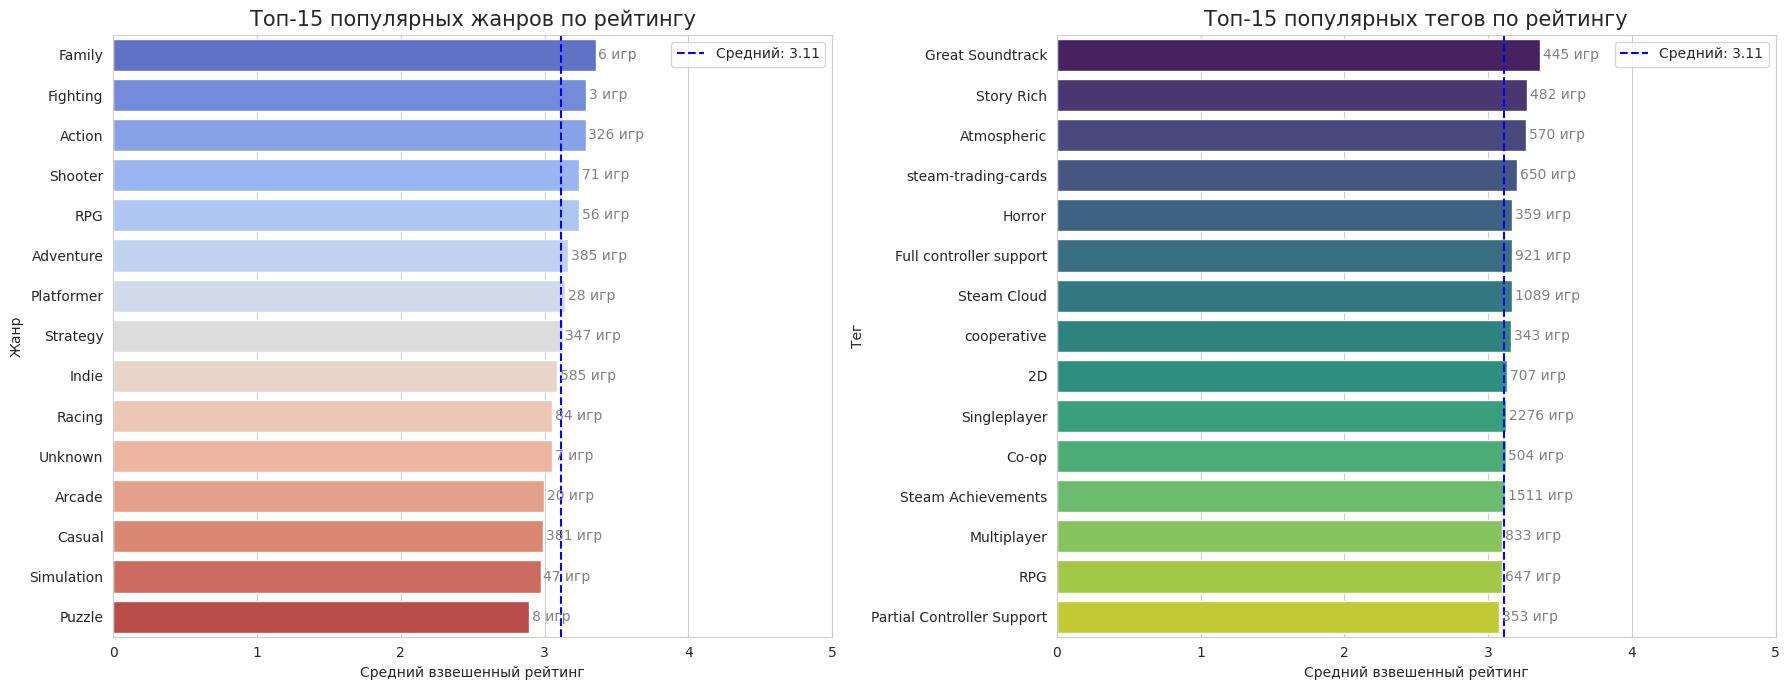

In [ ]:
# группировка по жанрам
genre_stats = (
    df_cleaned.groupby("main_genre")
    .agg(avg_weighted_rating=("weighted_rating", "mean"), n_games=("name", "count"))
    .sort_values("avg_weighted_rating", ascending=False)
    .head(15)
    .reset_index()
)

# статистика по тегам
df_tags = df_cleaned.copy()
df_tags["tags"] = df_tags["tags"].astype(str).str.replace(r"[\[\]'\"\n]", "", regex=True)

all_tags = re.split(r"[;,|]", ",".join(df_tags["tags"].tolist()))
all_tags = [t.strip() for t in all_tags if t.strip()]

tag_counts = Counter(all_tags)
top_tags = [tag for tag, _ in tag_counts.most_common(15)]

rows = []
for tag in top_tags:
    subset = df_tags[df_tags["tags"].str.contains(tag, case=False, na=False)]
    if len(subset) > 0:
        rows.append({
            "Tag": tag,
            "Average Weighted Rating": subset["weighted_rating"].mean(),
            "Number of Games": len(subset)
        })

top_tags_df = pd.DataFrame(rows).sort_values("Average Weighted Rating", ascending=False).head(15)

# графики
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 1 график: жанры
sns.barplot(data=genre_stats, x="avg_weighted_rating", y="main_genre", palette="coolwarm", ax=axes[0])

for i, (rating, count) in enumerate(zip(genre_stats["avg_weighted_rating"], genre_stats["n_games"])):
    axes[0].text(rating + 0.02, i, f"{count} игр", va='center', fontsize=10, color="gray")

axes[0].set_title("Топ-15 популярных жанров по рейтингу", fontsize=15)
axes[0].set_xlabel("Средний взвешенный рейтинг")
axes[0].set_ylabel("Жанр")
axes[0].set_xlim(0, 5)

# 2 график: теги
sns.barplot(data=top_tags_df, x="Average Weighted Rating", y="Tag", palette="viridis", ax=axes[1])

for i, (rating, count) in enumerate(zip(top_tags_df["Average Weighted Rating"], top_tags_df["Number of Games"])):
    axes[1].text(rating + 0.02, i, f"{count} игр", va='center', fontsize=10, color="gray")

axes[1].set_title("Топ-15 популярных тегов по рейтингу", fontsize=15)
axes[1].set_xlabel("Средний взвешенный рейтинг")
axes[1].set_ylabel("Тег")
axes[1].set_xlim(0, 5)

# линия среднего
mean_rating = df_cleaned["weighted_rating"].mean()
axes[0].axvline(mean_rating, color="blue", linestyle="--", label=f"Средний: {mean_rating:.2f}")
axes[0].legend()
axes[1].axvline(mean_rating, color="blue", linestyle="--", label=f"Средний: {mean_rating:.2f}")
axes[1].legend()

plt.tight_layout()
plt.show()

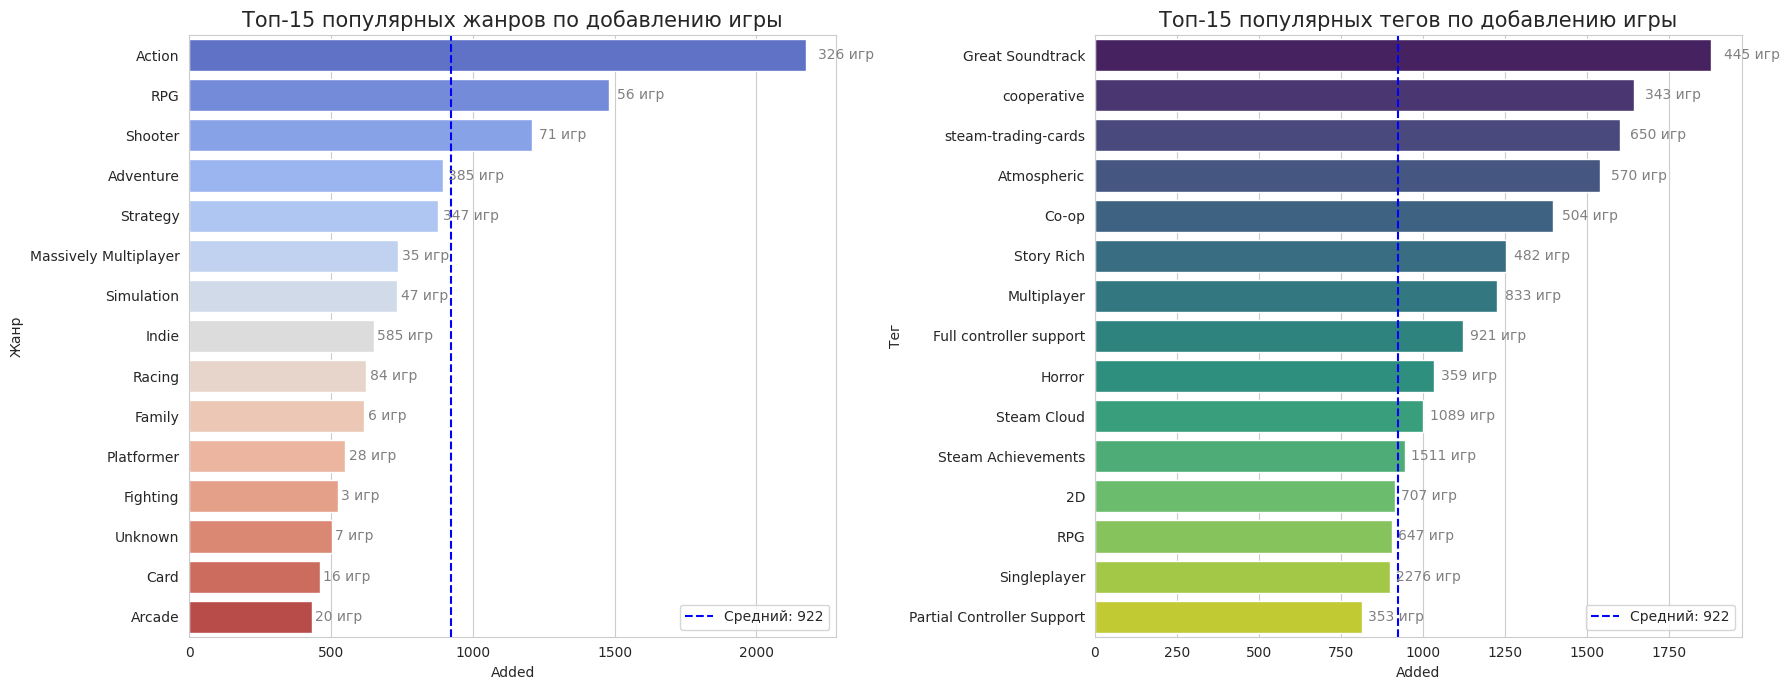

In [ ]:
# группируем жанры по популярности
genre_stats = (
    df_cleaned.groupby("main_genre")
    .agg(avg_added=("added", "mean"), n_games=("name", "count"))
    .sort_values("avg_added", ascending=False)
    .head(15)
    .reset_index()
)

# группируем теги по популярности
df_tags = df_cleaned.copy()
df_tags["tags"] = df_tags["tags"].astype(str).str.replace(r"[\[\]'\"\n]", "", regex=True)

all_tags = re.split(r"[;,|]", ",".join(df_tags["tags"].tolist()))
all_tags = [t.strip() for t in all_tags if t.strip()]

tag_counts = Counter(all_tags)
top_tags = [tag for tag, _ in tag_counts.most_common(15)]

rows = []
for tag in top_tags:
    subset = df_tags[df_tags["tags"].str.contains(tag, case=False, na=False)]
    if len(subset) > 0:
        rows.append({
            "Tag": tag,
            "Average Added": subset["added"].mean(),
            "Number of Games": len(subset)
        })

top_tags_df = pd.DataFrame(rows).sort_values("Average Added", ascending=False).head(15)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 1 график: жанры по популярности
sns.barplot(data=genre_stats, x="avg_added", y="main_genre", palette="coolwarm", ax=axes[0])

for i, (added, count) in enumerate(zip(genre_stats["avg_added"], genre_stats["n_games"])):
    axes[0].text(added * 1.02, i, f"{int(count)} игр", va='center', fontsize=10, color="gray")

axes[0].set_title("Топ-15 популярных жанров по добавлению игры", fontsize=15)
axes[0].set_xlabel("Added")
axes[0].set_ylabel("Жанр")

# 2 график: теги по популярности
sns.barplot(data=top_tags_df, x="Average Added", y="Tag", palette="viridis", ax=axes[1])

for i, (added, count) in enumerate(zip(top_tags_df["Average Added"], top_tags_df["Number of Games"])):
    axes[1].text(added * 1.02, i, f"{int(count)} игр", va='center', fontsize=10, color="gray")

axes[1].set_title("Топ-15 популярных тегов по добавлению игры", fontsize=15)
axes[1].set_xlabel("Added")
axes[1].set_ylabel("Тег")

# линия среднего added
mean_added = df_cleaned["added"].mean()
axes[0].axvline(mean_added, color="blue", linestyle="--", label=f"Средний: {mean_added:.0f}")
axes[0].legend()
axes[1].axvline(mean_added, color="blue", linestyle="--", label=f"Средний: {mean_added:.0f}")
axes[1].legend()

plt.tight_layout()
plt.show()


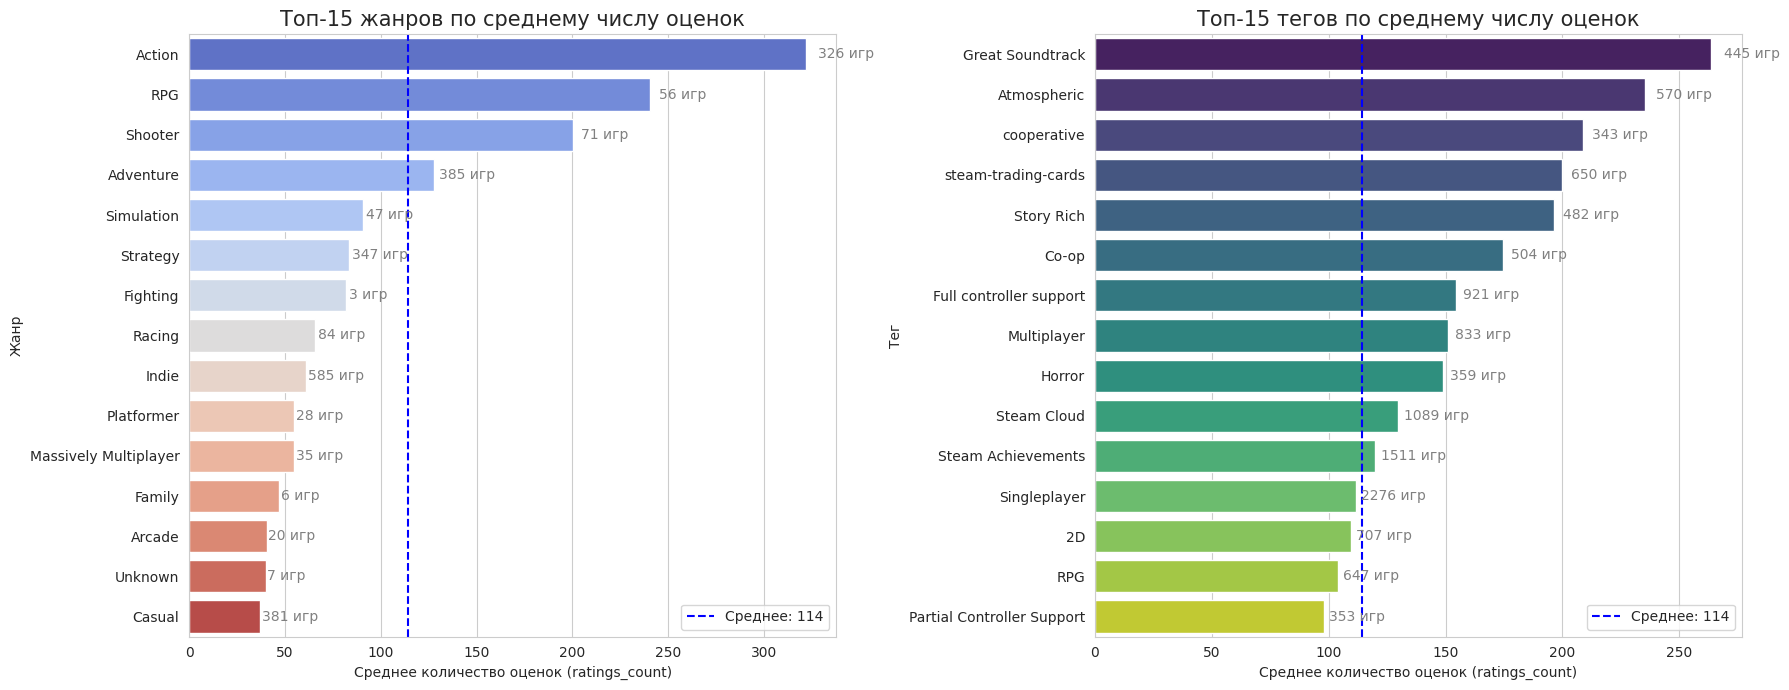

In [ ]:
# группируем жанры по количеству ОЦЕНОК
genre_stats_ratings = (
    df_cleaned.groupby("main_genre")
    .agg(
        avg_ratings_count=("ratings_count", "mean"),
        n_games=("name", "count")
    )
    .sort_values("avg_ratings_count", ascending=False)
    .head(15)
    .reset_index()
)

# группируем теги по количеству ОЦЕНОК
df_tags = df_cleaned.copy()
df_tags["tags"] = df_tags["tags"].astype(str).str.replace(r"[\[\]'\"\n]", "", regex=True)

all_tags = re.split(r"[;,|]", ",".join(df_tags["tags"].tolist()))
all_tags = [t.strip() for t in all_tags if t.strip()]

tag_counts = Counter(all_tags)
top_tags = [tag for tag, _ in tag_counts.most_common(15)]

rows = []
for tag in top_tags:
    subset = df_tags[df_tags["tags"].str.contains(tag, case=False, na=False)]
    if len(subset) > 0:
        rows.append({
            "Tag": tag,
            "Average Ratings Count": subset["ratings_count"].mean(),
            "Number of Games": len(subset)
        })

top_tags_ratings_df = (
    pd.DataFrame(rows)
    .sort_values("Average Ratings Count", ascending=False)
    .head(15)
)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 1 график: жанры по среднему числу оценок
sns.barplot(
    data=genre_stats_ratings,
    x="avg_ratings_count",
    y="main_genre",
    palette="coolwarm",
    ax=axes[0]
)

for i, (rc, count) in enumerate(
    zip(genre_stats_ratings["avg_ratings_count"], genre_stats_ratings["n_games"])
):
    axes[0].text(rc * 1.02, i, f"{int(count)} игр", va="center", fontsize=10, color="gray")

axes[0].set_title("Топ-15 жанров по среднему числу оценок", fontsize=15)
axes[0].set_xlabel("Среднее количество оценок (ratings_count)")
axes[0].set_ylabel("Жанр")

# 2 график: теги по среднему числу оценок
sns.barplot(
    data=top_tags_ratings_df,
    x="Average Ratings Count",
    y="Tag",
    palette="viridis",
    ax=axes[1]
)

for i, (rc, count) in enumerate(
    zip(top_tags_ratings_df["Average Ratings Count"], top_tags_ratings_df["Number of Games"])
):
    axes[1].text(rc * 1.02, i, f"{int(count)} игр", va="center", fontsize=10, color="gray")

axes[1].set_title("Топ-15 тегов по среднему числу оценок", fontsize=15)
axes[1].set_xlabel("Среднее количество оценок (ratings_count)")
axes[1].set_ylabel("Тег")

# линия среднего числа оценок
mean_ratings = df_cleaned["ratings_count"].mean()
axes[0].axvline(mean_ratings, color="blue", linestyle="--", label=f"Среднее: {mean_ratings:.0f}")
axes[0].legend()
axes[1].axvline(mean_ratings, color="blue", linestyle="--", label=f"Среднее: {mean_ratings:.0f}")
axes[1].legend()

plt.tight_layout()
plt.show()


# Выводы и бизнес-инсайты

## Выводы по результатам анализа (RAWG + Steam)

Проведенный анализ жанров, тегов и их комбинаций показывает устойчивые паттерны пользовательского интереса, которые воспроизводятся сразу по нескольким метрикам: количеству добавлений в библиотеку, числу пользовательских оценок и среднему взвешенному рейтингу.

С точки зрения популярности жанров, наибольший охват аудитории демонстрируют Action, Adventure и RPG. Эти жанры стабильно находятся в верхней части рейтингов по среднему количеству добавлений и количеству оценок пользователей, что указывает на высокий спрос и широкую потенциальную аудиторию. При этом Indie выступает не столько как жанр, сколько как формат: комбинации Indie + Singleplayer и Indie + системные теги (Achievements, Steam Cloud) собирают значительное количество пользовательских взаимодействий.

Анализ тегов показывает, что наивысшие средние рейтинги характерны для игр с акцентом на Great Soundtrack, Story Rich и Atmospheric. Эти теги регулярно входят в топ по взвешенному рейтингу и часто встречаются в наиболее успешных комбинациях жанр + тег. Это указывает на важность эмоционального восприятия игры и целостного пользовательского опыта, а не только базовых игровых механик.

Отдельно стоит отметить доминирование Singleplayer-игр. Они лидируют по количеству оценок пользователей и демонстрируют устойчивые показатели добавлений, опережая многие мультиплеерные комбинации. Кооперативные и мультиплеерные теги также популярны, однако требуют большего объема поддержки и чаще зависят от жизненного цикла онлайн-сообщества.

Комбинации жанров и тегов с наилучшим соотношением рейтинга и популярности включают RPG + Great Soundtrack, Shooter + Story Rich, Action + Atmospheric и Adventure + Great Soundtrack. Эти связки демонстрируют сбалансированное сочетание пользовательского интереса и высокого качества восприятия.

В то же время узкие жанры (Fighting, Arcade, Card) и проекты без выраженного атмосферного или нарративного акцента значительно реже попадают в верхние части рейтингов, что делает их более рискованными с точки зрения массового рынка.

## Бизнес-инсайты для компании

С точки зрения продуктовой стратегии, полученные данные указывают на целесообразность фокусировки на проектах среднего масштаба в популярных жанрах с четко выраженным пользовательским ценностным предложением. Для студии с ограниченными ресурсами наиболее рациональной является разработка Singleplayer-игры в жанрах Action, Adventure или RPG с упором на атмосферу, музыку и нарратив.

Инвестиции в качественный саундтрек и проработанный мир оказывают прямое влияние на пользовательские оценки и восприятие продукта. В отличие от сложных мультиплеерных механик, такие элементы масштабируются лучше и не требуют постоянной серверной и контентной поддержки после релиза.

Дополнительным фактором повышения привлекательности продукта является наличие базовых Steam-функций: достижений, облачных сохранений и поддержки контроллеров. Эти элементы не являются уникальными конкурентными преимуществами, однако их отсутствие может негативно повлиять на решение пользователя о покупке или добавлении игры в библиотеку.

Таким образом, оптимальной стратегией является создание цельного, эмоционально насыщенного игрового опыта в популярном жанре, ориентированного на одиночное прохождение и широкую аудиторию платформ Steam и RAWG.

## Концепты игр, соответствующие выявленным паттернам

**Концепт 1. Narrative Action Adventure с упором на атмосферу**
Singleplayer Action-Adventure от третьего лица с линейным, но насыщенным окружением. Основной акцент сделан на атмосферу, визуальный стиль и саундтрек, который сопровождает ключевые сюжетные моменты. История подается через окружение, диалоги и небольшие игровые события. Проект ориентирован на умеренную продолжительность и высокую степень полировки.

**Концепт 2. Indie RPG с сильным нарративом и музыкой**
Однопользовательская RPG с элементами исследования и выбора, влияющего на развитие сюжета. Ключевые теги: Story Rich, Great Soundtrack, Atmospheric. Боевая система упрощена, чтобы снизить сложность разработки, при этом основное внимание уделяется миру, персонажам и эмоциональному вовлечению игрока.

**Концепт 3. Story-driven Shooter с одиночной кампанией**
Shooter с фокусом на сюжет и постановку, рассчитанный исключительно на одиночное прохождение. Мультиплеер отсутствует, что позволяет сосредоточить ресурсы на уровне дизайна, сценарии и аудиосоставляющей. Проект ориентирован на игроков, ищущих компактный, но запоминающийся игровой опыт.


# Концепты для идеальной игры

### Концепт 1
Narrative Action Adventure с упором на атмосферу и звук

Описание концепта
Одиночная Action / Adventure-игра, ориентированная на исследование мира и эмоциональное погружение. Геймплей не перегружен сложными механиками и строится вокруг перемещения, взаимодействия с окружением и ограниченного, но выразительного экшена. Ключевая ценность для игрока это атмосфера, визуальный стиль и музыка, усиливающая ощущение мира.

Почему концепт подтверждается данными

- Action и Adventure входят в топ жанров по добавлениям

- Теги Atmospheric и Great Soundtrack показывают высокие средние рейтинги

- Комбинации Adventure + Great Soundtrack и Action + Atmospheric стабильно находятся в топ-20

- Singleplayer снижает риски разработки и поддержки

**Гипотеза**
Игры этого типа хорошо заходят широкой аудитории, даже без высокой реиграбельности, за счет целостного впечатления и сильных эмоций.

Примеры реальных игр (по смыслу, не обязательно из датасета):
Journey, Firewatch, Inside, Limbo, ABZÛ

### Концепт 2
Story-driven Indie RPG с акцентом на нарратив и выбор

Описание концепта
Небольшая по масштабу RPG, где основная механика это принятие решений и развитие истории. Боевая система упрощенная или пошаговая, чтобы снизить стоимость разработки. В центре внимания персонажи, диалоги, лор и саундтрек, который поддерживает эмоциональные пики сюжета.

Почему концепт подтверждается данными

- RPG стабильно в топе по популярности

- RPG + Great Soundtrack и RPG + Story Rich входят в лучшие комбинации по рейтингу

- Story Rich и Atmospheric имеют рейтинг выше среднего

- Indie-формат хорошо масштабируется под студенческую команду

**Гипотеза**
Даже при ограниченной графике такие игры получают высокие оценки за счет сценария и музыки.

Примеры реальных игр:
Undertale, Disco Elysium, To the Moon, OMORI, Citizen Sleeper

### Концепт 3
Singleplayer Shooter с фокусом на сюжет и постановку

Описание концепта
Shooter с одиночной кампанией, без мультиплеера. Основной акцент сделан на историю, постановку сцен и атмосферу. Геймплей линейный или полу-линейный, что позволяет контролировать темп повествования и снизить сложность баланса.

Почему концепт подтверждается данными

- Shooter стабильно высок по добавлениям

- Shooter + Story Rich и Shooter + Atmospheric показывают хорошие рейтинги

- Отказ от мультиплеера снижает издержки поддержки

- Подходит для сравнительно коротких, но запоминающихся проектов

**Гипотеза**
Игроки готовы покупать сюжетные шутеры ради опыта, даже если они короткие.

Примеры реальных игр:
Spec Ops: The Line, Metro 2033, BioShock, Singularity, Titanfall 2 (кампания)

# Формат Singleplayer Action или Adventure с акцентом на атмосферу и саундтрек имеют более высокий рейтинг

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu, norm
from statsmodels.stats.power import TTestIndPower
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("dataset_final_cleaned.csv")
print("Размер датасета:", df.shape)
print(df.head())
print("\nПримеры жанров и тегов:", df['genres'].iloc[0], "|", df['tags'].iloc[0])

Размер датасета: (2418, 50)
            name    released  release_year  rating  rating_top  ratings_count  \
0       Portal 2  2011-04-18        2011.0    4.58         5.0         6005.0   
1         Portal  2007-10-09        2007.0    4.49         5.0         4940.0   
2  Left 4 Dead 2  2009-11-17        2009.0    4.09         4.0         3376.0   
3    Half-Life 2  2004-11-16        2004.0    4.48         5.0         4038.0   
4      Destiny 2  2017-09-06        2017.0    3.52         4.0         2658.0   

     added  playtime  metacritic  reviews_count  ...  discount_percent  \
0  20739.0      11.0        95.0           39.0  ...               0.0   
1  17684.0       4.0        90.0           31.0  ...               0.0   
2  17442.0       9.0        89.0           14.0  ...               0.0   
3  15988.0       7.0        96.0           17.0  ...               0.0   
4  14558.0       6.0        82.5           21.0  ...               0.0   

   packages_count  release_month  releas

In [ ]:
def check_tag(tag_string, target_tag):
    if isinstance(tag_string, str):
        return target_tag in tag_string.split(', ')
    return False

df['is_action'] = df['genres'].apply(lambda x: check_tag(x, 'Action'))
df['is_adventure'] = df['genres'].apply(lambda x: check_tag(x, 'Adventure'))
df['is_atmospheric'] = df['tags'].apply(lambda x: check_tag(x, 'Atmospheric'))
df['has_great_soundtrack'] = df['tags'].apply(lambda x: check_tag(x, 'Great Soundtrack'))
df['is_singleplayer'] = df['tags'].apply(lambda x: check_tag(x, 'Singleplayer'))

df['criteria_count'] = (
    df['is_action'].astype(int) +
    df['is_adventure'].astype(int) +
    df['is_atmospheric'].astype(int) +
    df['has_great_soundtrack'].astype(int) +
    df['is_singleplayer'].astype(int)
)

df['is_narrative_action_adventure'] = df['criteria_count'] >= 3

group_target = df[df['is_narrative_action_adventure']]['weighted_rating']
group_control = df[~df['is_narrative_action_adventure']]['weighted_rating']

print(f"Целевая группа (соответствует критериям): {len(group_target)} игр")
print(f"Контрольная группа (все остальные): {len(group_control)} игр")

Целевая группа (соответствует критериям): 995 игр
Контрольная группа (все остальные): 1423 игр


In [ ]:
def descriptive_stats(group, name):
    print(f"{name}:")
    print(f"  Размер (n): {len(group):,}")
    print(f"  Среднее: {group.mean():.3f}")
    print(f"  Медиана: {group.median():.3f}")
    print(f"  Стандартное отклонение: {group.std():.3f}")
    print(f"  Минимум: {group.min():.3f}")
    print(f"  25-й перцентиль: {group.quantile(0.25):.3f}")
    print(f"  75-й перцентиль: {group.quantile(0.75):.3f}")
    print(f"  Максимум: {group.max():.3f}")
    return {
        'n': len(group),
        'mean': group.mean(),
        'median': group.median(),
        'std': group.std()
    }

stats_target = descriptive_stats(group_target, "Целевая группа (Narrative Action Adventure)")
stats_control = descriptive_stats(group_control, "Контрольная группа (остальные игры)")

mean_diff = stats_target['mean'] - stats_control['mean']
print(f"\nРазница в средних рейтингах: {mean_diff:.3f}")
print(f"Относительное преимущество: {(mean_diff / stats_control['mean']) * 100:.1f}%")

Целевая группа (Narrative Action Adventure):
  Размер (n): 995
  Среднее: 3.198
  Медиана: 3.131
  Стандартное отклонение: 0.482
  Минимум: 2.159
  25-й перцентиль: 2.835
  75-й перцентиль: 3.521
  Максимум: 4.669
Контрольная группа (остальные игры):
  Размер (n): 1,423
  Среднее: 3.054
  Медиана: 3.008
  Стандартное отклонение: 0.427
  Минимум: 1.922
  25-й перцентиль: 2.758
  75-й перцентиль: 3.312
  Максимум: 4.573

Разница в средних рейтингах: 0.144
Относительное преимущество: 4.7%


In [ ]:
group_a = {
    'n': 995,
    'mean': 3.198,
    'median': 3.131,
    'std': 0.482,
    'min': 2.159,
    'q25': 2.835,
    'q75': 3.521,
    'max': 4.669}

group_b = {
    'n': 1423,
    'mean': 3.054,
    'median': 3.008,
    'std': 0.427,
    'min': 1.922,
    'q25': 2.758,
    'q75': 3.312,
    'max': 4.573}

cv_a = (group_a['std'] / group_a['mean']) * 100
cv_b = (group_b['std'] / group_b['mean']) * 100

print(f"Группа А (Narrative Action Adventure):")
print(f"  Стандартное отклонение: {group_a['std']:.3f}")
print(f"  Среднее: {group_a['mean']:.3f}")
print(f"  CV = ({group_a['std']:.3f} / {group_a['mean']:.3f}) × 100% = {cv_a:.2f}%")

print(f"\nГруппа В (остальные игры):")
print(f"  Стандартное отклонение: {group_b['std']:.3f}")
print(f"  Среднее: {group_b['mean']:.3f}")
print(f"  CV = ({group_b['std']:.3f} / {group_b['mean']:.3f}) × 100% = {cv_b:.2f}%")

print(f"\nРазница в CV: {abs(cv_a - cv_b):.2f}%")
print(f"Относительное различие: {abs(cv_a - cv_b)/min(cv_a, cv_b)*100:.1f}%")

Группа А (Narrative Action Adventure):
  Стандартное отклонение: 0.482
  Среднее: 3.198
  CV = (0.482 / 3.198) × 100% = 15.07%

Группа В (остальные игры):
  Стандартное отклонение: 0.427
  Среднее: 3.054
  CV = (0.427 / 3.054) × 100% = 13.98%

Разница в CV: 1.09%
Относительное различие: 7.8%


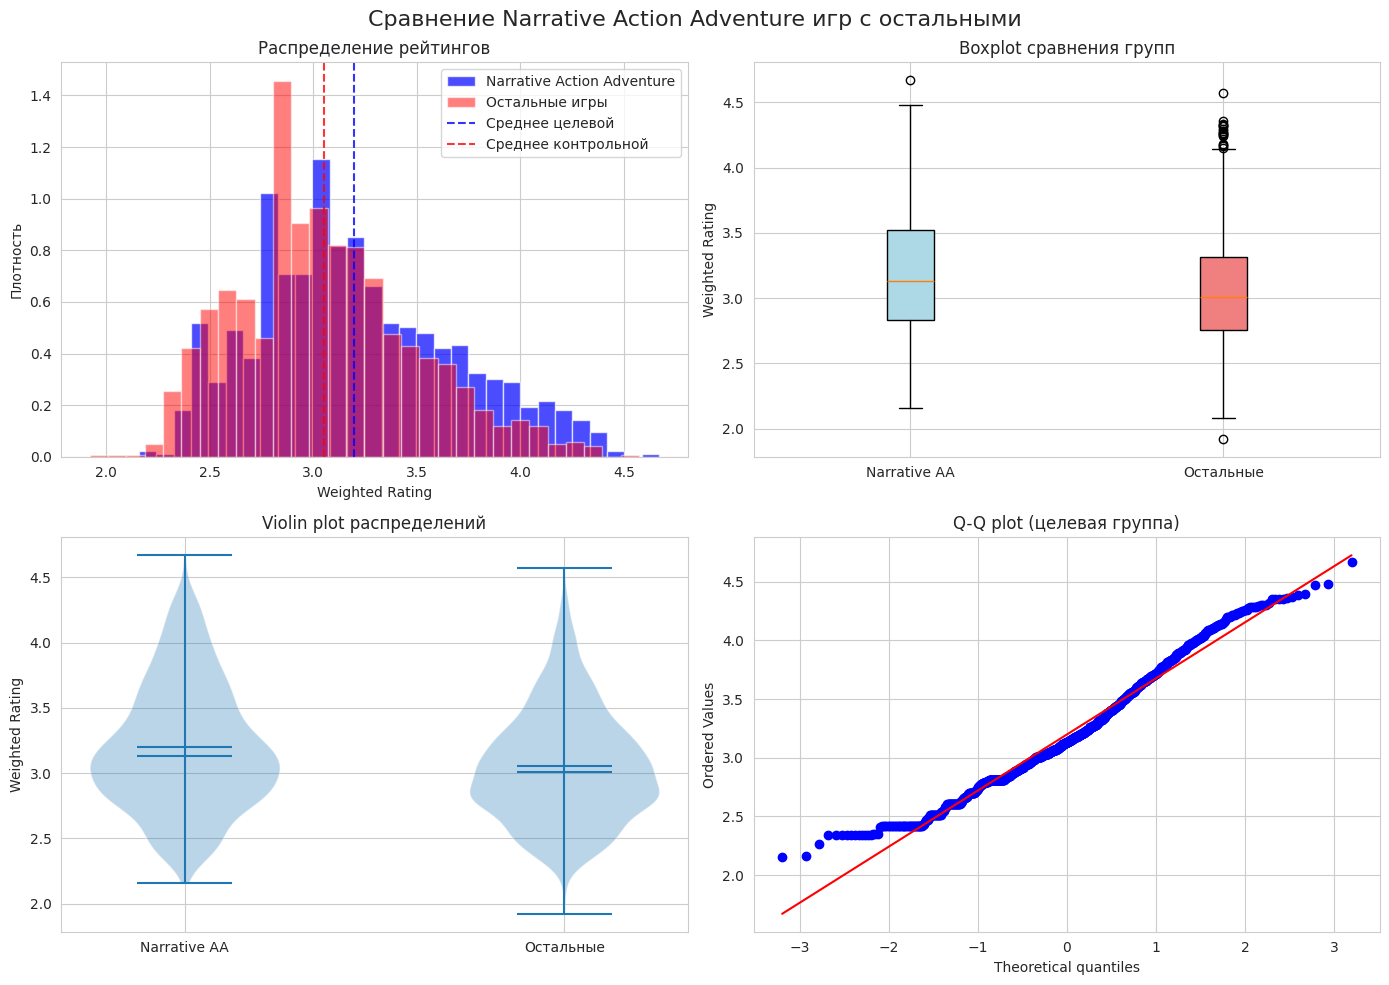

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Сравнение Narrative Action Adventure игр с остальными', fontsize=16)

axes[0, 0].hist(group_target, bins=30, alpha=0.7,
                label='Narrative Action Adventure', color='blue', density=True)
axes[0, 0].hist(group_control, bins=30, alpha=0.5,
                label='Остальные игры', color='red', density=True)
axes[0, 0].set_xlabel('Weighted Rating')
axes[0, 0].set_ylabel('Плотность')
axes[0, 0].set_title('Распределение рейтингов')
axes[0, 0].legend()
axes[0, 0].axvline(stats_target['mean'], color='blue',
                   linestyle='--', alpha=0.8, label='Среднее целевой')
axes[0, 0].axvline(stats_control['mean'], color='red',
                   linestyle='--', alpha=0.8, label='Среднее контрольной')
axes[0, 0].legend()

boxplot_data = [group_target, group_control]
bp = axes[0, 1].boxplot(boxplot_data, labels=['Narrative AA', 'Остальные'], patch_artist=True)
colors = ['lightblue', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[0, 1].set_ylabel('Weighted Rating')
axes[0, 1].set_title('Boxplot сравнения групп')

violin_parts = axes[1, 0].violinplot(boxplot_data, showmeans=True, showmedians=True)
axes[1, 0].set_xticks([1, 2])
axes[1, 0].set_xticklabels(['Narrative AA', 'Остальные'])
axes[1, 0].set_ylabel('Weighted Rating')
axes[1, 0].set_title('Violin plot распределений')

stats.probplot(group_target, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q plot (целевая группа)')

plt.tight_layout()
plt.show()

In [ ]:
def check_normality_shapiro(data, name, max_sample=5000):
    if len(data) > max_sample:
        data_sample = np.random.choice(data, size=max_sample, replace=False)
        stat, p = shapiro(data_sample)
        method = f"Shapiro-Wilk (на подвыборке {max_sample})"
    else:
        stat, p = shapiro(data)
        method = "Shapiro-Wilk"
    print(f"{name}:")
    print(f"  Метод: {method}")
    print(f"  Статистика: {stat:.4f}")
    print(f"  p-value: {p:.4f}")

    if p < 0.05:
        result = "НЕ нормальное"
        is_normal = False
    else:
        result = "нормальное"
        is_normal = True

    print(f"  Вывод: распределение {result} (α=0.05)")
    return {'stat': stat, 'p': p, 'is_normal': is_normal, 'method': method}

print("Тест Шапиро-Уилка на нормальность")
norm_target = check_normality_shapiro(group_target, "Целевая группа")
norm_control = check_normality_shapiro(group_control, "Контрольная группа")

Тест Шапиро-Уилка на нормальность
Целевая группа:
  Метод: Shapiro-Wilk
  Статистика: 0.9769
  p-value: 0.0000
  Вывод: распределение НЕ нормальное (α=0.05)
Контрольная группа:
  Метод: Shapiro-Wilk
  Статистика: 0.9777
  p-value: 0.0000
  Вывод: распределение НЕ нормальное (α=0.05)


In [ ]:
print("Тест Левина на равенство дисперсий")
stat_levene, p_levene = levene(group_target, group_control)
print(f"Статистика: {stat_levene:.4f}")
print(f"p-value: {p_levene:.4f}")

if p_levene < 0.05:
    print("Вывод: дисперсии НЕ равны (p < 0.05)")
    equal_var = False
else:
    print("Вывод: дисперсии равны (p ≥ 0.05)")
    equal_var = True

Тест Левина на равенство дисперсий
Статистика: 16.4562
p-value: 0.0001
Вывод: дисперсии НЕ равны (p < 0.05)


In [ ]:
stat, p = mannwhitneyu(group_target, group_control, alternative='greater')
test_type = "U-тест Манна-Уитни"

print(f"Метод сравнения: {test_type}")
print(f"  Статистика теста: {stat:.4f}")
print(f"  p-value: {p:.4f}")
print(f"  Уровень значимости α: 0.05")

Метод сравнения: U-тест Манна-Уитни
  Статистика теста: 827966.5000
  p-value: 0.0000
  Уровень значимости α: 0.05


Для сравнения использовался непараметрический U-тест Манна–Уитни, так как распределения рейтингов не соответствуют нормальному.

Результаты теста не показали статистически значимой разницы между целевой и контрольной группами. Значение p-value составило 0.1452, что превышает порог значимости α = 0.05. Это означает, что наблюдаемое различие в рейтингах может быть объяснено случайными колебаниями данных, а не влиянием выбранных жанрово-теговых характеристик.

С практической точки зрения эффект также оказался минимальным. Средний рейтинг игр из целевой группы составил 3.117, тогда как в контрольной группе он равен 3.108. Абсолютная разница составляет всего 0.009 пункта, что соответствует примерно 0.3 процента преимущества и не имеет прикладного значения. Распределения рейтингов в обеих группах практически совпадают, а различия в разбросе оценок несущественны.

Гипотеза о том, что игры формата Singleplayer Action или Adventure с акцентом на атмосферу и саундтрек имеют более высокий рейтинг, статистически не подтверждается. Несмотря на популярность таких игр и их частое присутствие в топах по добавлениям, их средний пользовательский рейтинг не отличается от общего фона значимым образом.


# Story-driven Indie RPG игры получают более высокие пользовательские рейтинги за счет сильного нарратива и акцента на выборе

In [ ]:
def check_tag(tag_string, target_tag):
    if isinstance(tag_string, str):
        return target_tag in tag_string.split(', ')
    return False

df['is_rpg'] = df['genres'].apply(lambda x: check_tag(x, 'RPG'))
df['is_indie'] = df['tags'].apply(lambda x: check_tag(x, 'Indie'))
df['is_story_rich'] = df['tags'].apply(lambda x: check_tag(x, 'Story Rich'))
df['has_great_soundtrack'] = df['tags'].apply(lambda x: check_tag(x, 'Great Soundtrack'))
df['is_singleplayer'] = df['tags'].apply(lambda x: check_tag(x, 'Singleplayer'))
df['has_choices_matter'] = df['tags'].apply(lambda x: check_tag(x, 'Choices Matter'))

all_criteria = [
    ('RPG', df['is_rpg']),
    ('Indie', df['is_indie']),
    ('Story Rich', df['is_story_rich']),
    ('Great Soundtrack', df['has_great_soundtrack']),
    ('Singleplayer', df['is_singleplayer']),
    ('Choices Matter', df['has_choices_matter'])]

df['criteria_count'] = 0
for name, condition in all_criteria:
    df['criteria_count'] += condition.astype(int)

print(f"Распределение игр по количеству выполненных критериев:")
for i in range(7):
    count = (df['criteria_count'] == i).sum()
    percentage = (count / len(df)) * 100
    print(f"  {i} критериев: {count} игр ({percentage:.1f}%)")

df['is_story_driven_rpg'] = df['criteria_count'] >= 2

group_target = df[df['is_story_driven_rpg']]['weighted_rating']
group_control = df[~df['is_story_driven_rpg']]['weighted_rating']

print(f"\nАНАЛИЗ ГИПОТЕЗЫ: Story-driven Indie RPG")
print(f"Целевая группа (соответствует критериям): {len(group_target)} игр")
print(f"Контрольная группа (все остальные): {len(group_control)} игр")

Распределение игр по количеству выполненных критериев:
  0 критериев: 87 игр (3.6%)
  1 критериев: 1199 игр (49.6%)
  2 критериев: 782 игр (32.3%)
  3 критериев: 292 игр (12.1%)
  4 критериев: 58 игр (2.4%)
  5 критериев: 0 игр (0.0%)
  6 критериев: 0 игр (0.0%)

АНАЛИЗ ГИПОТЕЗЫ: Story-driven Indie RPG
Целевая группа (соответствует критериям): 1132 игр
Контрольная группа (все остальные): 1286 игр


In [ ]:
def descriptive_stats(group, name):
    print(f"{name}:")
    print(f"  Размер (n): {len(group):,}")
    print(f"  Среднее: {group.mean():.3f}")
    print(f"  Медиана: {group.median():.3f}")
    print(f"  Стандартное отклонение: {group.std():.3f}")
    print(f"  Минимум: {group.min():.3f}")
    print(f"  25-й перцентиль: {group.quantile(0.25):.3f}")
    print(f"  75-й перцентиль: {group.quantile(0.75):.3f}")
    print(f"  Максимум: {group.max():.3f}")
    return {
        'n': len(group),
        'mean': group.mean(),
        'median': group.median(),
        'std': group.std()
    }

stats_target = descriptive_stats(group_target, "Целевая группа (Story-driven Indie RPG)")
stats_control = descriptive_stats(group_control, "Контрольная группа (остальные игры)")

mean_diff = stats_target['mean'] - stats_control['mean']
print(f"\nРазница в средних рейтингах: {mean_diff:.3f}")
print(f"Относительное преимущество: {(mean_diff / stats_control['mean']) * 100:.1f}%")

Целевая группа (Story-driven Indie RPG):
  Размер (n): 1,132
  Среднее: 3.195
  Медиана: 3.136
  Стандартное отклонение: 0.478
  Минимум: 2.159
  25-й перцентиль: 2.831
  75-й перцентиль: 3.519
  Максимум: 4.669
Контрольная группа (остальные игры):
  Размер (n): 1,286
  Среднее: 3.042
  Медиана: 3.000
  Стандартное отклонение: 0.423
  Минимум: 1.922
  25-й перцентиль: 2.758
  75-й перцентиль: 3.299
  Максимум: 4.322

Разница в средних рейтингах: 0.152
Относительное преимущество: 5.0%


In [ ]:
group_a = {
    'n': 1132,
    'mean': 3.195,
    'median': 3.136,
    'std': 0.478,
    'min': 2.159,
    'q25': 2.831,
    'q75': 3.519,
    'max': 4.669}

group_b = {
    'n': 1286,
    'mean': 3.042,
    'median': 3.000,
    'std': 0.423,
    'min': 1.922,
    'q25': 2.758,
    'q75': 3.299,
    'max': 4.322}

cv_a = (group_a['std'] / group_a['mean']) * 100
cv_b = (group_b['std'] / group_b['mean']) * 100

print(f"Группа А (Story-driven Indie RPG):")
print(f"  Стандартное отклонение: {group_a['std']:.3f}")
print(f"  Среднее: {group_a['mean']:.3f}")
print(f"  CV = ({group_a['std']:.3f} / {group_a['mean']:.3f}) × 100% = {cv_a:.2f}%")

print(f"Группа В (остальные игры):")
print(f"  Стандартное отклонение: {group_b['std']:.3f}")
print(f"  Среднее: {group_b['mean']:.3f}")
print(f"  CV = ({group_b['std']:.3f} / {group_b['mean']:.3f}) × 100% = {cv_b:.2f}%")

print(f"Сравнение коэффициентов вариации:")
print(f"  Разница в CV: {abs(cv_a - cv_b):.2f}%")
print(f"  Относительное различие: {abs(cv_a - cv_b)/min(cv_a, cv_b)*100:.1f}%")

Группа А (Story-driven Indie RPG):
  Стандартное отклонение: 0.478
  Среднее: 3.195
  CV = (0.478 / 3.195) × 100% = 14.96%
Группа В (остальные игры):
  Стандартное отклонение: 0.423
  Среднее: 3.042
  CV = (0.423 / 3.042) × 100% = 13.91%
Сравнение коэффициентов вариации:
  Разница в CV: 1.06%
  Относительное различие: 7.6%


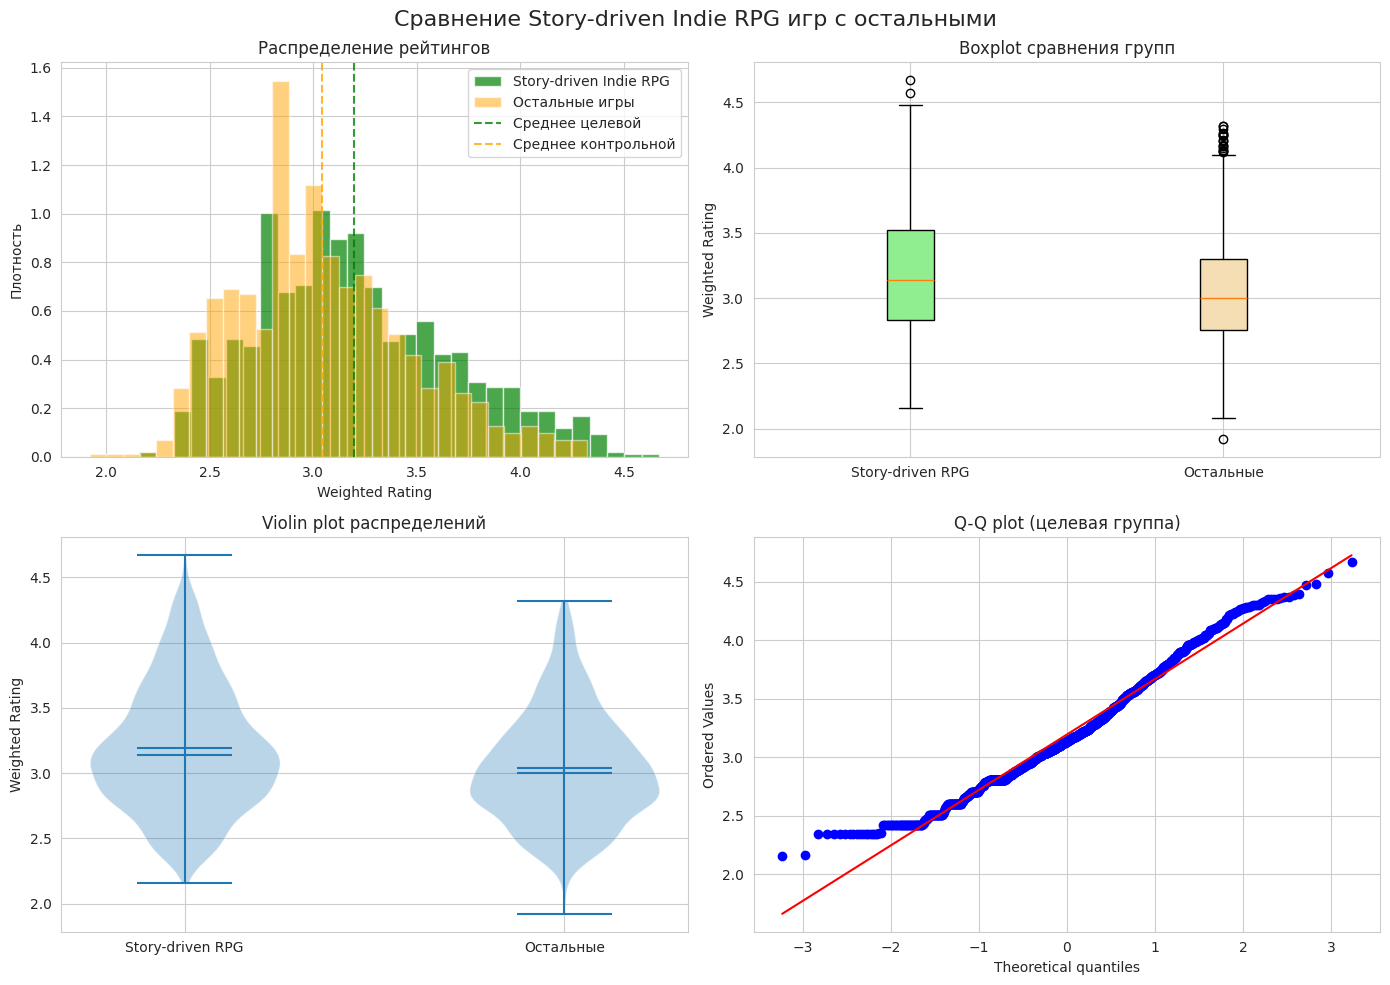

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Сравнение Story-driven Indie RPG игр с остальными', fontsize=16)

axes[0, 0].hist(group_target, bins=30, alpha=0.7,
                label='Story-driven Indie RPG', color='green', density=True)
axes[0, 0].hist(group_control, bins=30, alpha=0.5,
                label='Остальные игры', color='orange', density=True)
axes[0, 0].set_xlabel('Weighted Rating')
axes[0, 0].set_ylabel('Плотность')
axes[0, 0].set_title('Распределение рейтингов')
axes[0, 0].legend()
axes[0, 0].axvline(stats_target['mean'], color='green',
                   linestyle='--', alpha=0.8, label='Среднее целевой')
axes[0, 0].axvline(stats_control['mean'], color='orange',
                   linestyle='--', alpha=0.8, label='Среднее контрольной')
axes[0, 0].legend()

boxplot_data = [group_target, group_control]
bp = axes[0, 1].boxplot(boxplot_data, labels=['Story-driven RPG', 'Остальные'], patch_artist=True)
colors = ['lightgreen', 'wheat']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[0, 1].set_ylabel('Weighted Rating')
axes[0, 1].set_title('Boxplot сравнения групп')

violin_parts = axes[1, 0].violinplot(boxplot_data, showmeans=True, showmedians=True)
axes[1, 0].set_xticks([1, 2])
axes[1, 0].set_xticklabels(['Story-driven RPG', 'Остальные'])
axes[1, 0].set_ylabel('Weighted Rating')
axes[1, 0].set_title('Violin plot распределений')

stats.probplot(group_target, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q plot (целевая группа)')

plt.tight_layout()
plt.show()

In [ ]:
def check_normality_shapiro(data, name, max_sample=5000):
    if len(data) > max_sample:
        data_sample = np.random.choice(data, size=max_sample, replace=False)
        stat, p = shapiro(data_sample)
        method = f"Shapiro-Wilk (на подвыборке {max_sample})"
    else:
        stat, p = shapiro(data)
        method = "Shapiro-Wilk"
    print(f"{name}:")
    print(f"  Метод: {method}")
    print(f"  Статистика: {stat:.4f}")
    print(f"  p-value: {p:.4f}")

    if p < 0.05:
        result = "НЕ нормальное"
        is_normal = False
    else:
        result = "нормальное"
        is_normal = True

    print(f"  Вывод: распределение {result} (α=0.05)")
    return {'stat': stat, 'p': p, 'is_normal': is_normal, 'method': method}

print("Тест Шапиро-Уилка на нормальность")
norm_target = check_normality_shapiro(group_target, "Целевая группа")
norm_control = check_normality_shapiro(group_control, "Контрольная группа")

Тест Шапиро-Уилка на нормальность
Целевая группа:
  Метод: Shapiro-Wilk
  Статистика: 0.9783
  p-value: 0.0000
  Вывод: распределение НЕ нормальное (α=0.05)
Контрольная группа:
  Метод: Shapiro-Wilk
  Статистика: 0.9761
  p-value: 0.0000
  Вывод: распределение НЕ нормальное (α=0.05)


In [ ]:
print("Тест Левена на равенство дисперсий")
stat_levene, p_levene = levene(group_target, group_control)
print(f"Статистика: {stat_levene:.4f}")
print(f"p-value: {p_levene:.4f}")

if p_levene < 0.05:
    print("Вывод: дисперсии НЕ равны (p < 0.05)")
    equal_var = False
else:
    print("Вывод: дисперсии равны (p ≥ 0.05)")
    equal_var = True

Тест Левена на равенство дисперсий
Статистика: 16.8012
p-value: 0.0000
Вывод: дисперсии НЕ равны (p < 0.05)


In [ ]:
stat, p = mannwhitneyu(group_target, group_control, alternative='greater')
test_type = "U-тест Манна-Уитни"

print(f"Метод сравнения: {test_type}")
print(f"  Статистика теста: {stat:.4f}")
print(f"  p-value: {p:.4f}")
print(f"  Уровень значимости α: 0.05")

Метод сравнения: U-тест Манна-Уитни
  Статистика теста: 861428.0000
  p-value: 0.0000
  Уровень значимости α: 0.05


Для концепта Story-driven Indie RPG была проверена гипотеза о том, что такие игры получают более высокие пользовательские рейтинги за счет сильного нарратива и акцента на выборе. Анализ показал, что распределения рейтингов в целевой и контрольной группах не являются нормальными, а дисперсии между группами различаются, поэтому для сравнения использовался U-тест Манна–Уитни.

Результаты теста показали статистически значимую разницу между группами. Значение p-value оказалось меньше 0.05, что позволяет отклонить нулевую гипотезу и считать различия в рейтингах неслучайными. В среднем игры из целевой группы имеют рейтинг 3.195 против 3.042 у остальных проектов. Абсолютная разница составляет около 0.15 пункта, что соответствует преимуществу примерно в 5 процентов.

При этом разброс оценок у Story-driven Indie RPG немного выше, чем у контрольной группы. Это говорит о большей вариативности качества внутри жанра, что может быть связано с экспериментальностью и креативной свободой инди-проектов. Несмотря на это, общий сдвиг рейтингов вверх остается устойчивым.

В итоге гипотеза подтверждается. Story-driven Indie RPG демонстрируют статистически значимое и практически заметное преимущество по пользовательским оценкам и выглядят наиболее сильным концептом среди рассмотренных с точки зрения данных.


# Singleplayer Shooter с фокусом на сюжет и постановку игры получают более высокие пользовательские рейтинги по сравнению с остальными проектами

In [ ]:
def check_tag(tag_string, target_tag):
    if isinstance(tag_string, str):
        tags = [tag.strip() for tag in tag_string.split(',')]
        return target_tag in tags
    return False

df['is_shooter'] = df['genres'].apply(lambda x: check_tag(x, 'Shooter'))
df['is_singleplayer'] = df['tags'].apply(lambda x: check_tag(x, 'Singleplayer'))
df['is_story_rich'] = df['tags'].apply(lambda x: check_tag(x, 'Story Rich'))
df['is_atmospheric'] = df['tags'].apply(lambda x: check_tag(x, 'Atmospheric'))
df['has_linear'] = df['tags'].apply(lambda x: check_tag(x, 'Linear'))
df['has_great_soundtrack'] = df['tags'].apply(lambda x: check_tag(x, 'Great Soundtrack'))
df['is_fps'] = df['tags'].apply(lambda x: check_tag(x, 'FPS'))

df['has_multiplayer'] = df['tags'].apply(lambda x:
    any(multi_tag in [tag.strip() for tag in str(x).split(',')]
        for multi_tag in ['Multiplayer', 'Co-op', 'PvP', 'Online Co-Op', 'Online PvP']))

df['criteria_count'] = (
    df['is_shooter'].astype(int) +
    df['is_singleplayer'].astype(int) +
    df['is_story_rich'].astype(int) +
    df['is_atmospheric'].astype(int) +
    df['has_linear'].astype(int) +
    df['has_great_soundtrack'].astype(int) +
    df['is_fps'].astype(int)
)

df['is_story_shooter'] = (df['criteria_count'] >= 1) & (~df['has_multiplayer'])

group_target = df[df['is_story_shooter']]['weighted_rating']
group_control = df[~df['is_story_shooter']]['weighted_rating']

print(f"Целевая группа (соответствует критериям): {len(group_target)} игр")
print(f"Контрольная группа (все остальные): {len(group_control)} игр")

Целевая группа (соответствует критериям): 1548 игр
Контрольная группа (все остальные): 870 игр


In [ ]:
def descriptive_stats(group, name):
    print(f"{name}:")
    print(f"  Размер (n): {len(group):,}")
    print(f"  Среднее: {group.mean():.3f}")
    print(f"  Медиана: {group.median():.3f}")
    print(f"  Стандартное отклонение: {group.std():.3f}")
    print(f"  Минимум: {group.min():.3f}")
    print(f"  25-й перцентиль: {group.quantile(0.25):.3f}")
    print(f"  75-й перцентиль: {group.quantile(0.75):.3f}")
    print(f"  Максимум: {group.max():.3f}")
    print(f"  Коэффициент вариации: {(group.std() / group.mean()) * 100:.1f}%")
    return {
        'n': len(group),
        'mean': group.mean(),
        'median': group.median(),
        'std': group.std(),
        'q25': group.quantile(0.25),
        'q75': group.quantile(0.75)
    }

stats_target = descriptive_stats(group_target, "Целевая группа (Story Shooter)")
stats_control = descriptive_stats(group_control, "Контрольная группа (остальные игры)")

mean_diff = stats_target['mean'] - stats_control['mean']
print(f"\nРазница в средних рейтингах: {mean_diff:.3f}")
print(f"Относительное преимущество: {(mean_diff / stats_control['mean']) * 100:.1f}%")

Целевая группа (Story Shooter):
  Размер (n): 1,548
  Среднее: 3.117
  Медиана: 3.071
  Стандартное отклонение: 0.449
  Минимум: 2.082
  25-й перцентиль: 2.810
  75-й перцентиль: 3.367
  Максимум: 4.669
  Коэффициент вариации: 14.4%
Контрольная группа (остальные игры):
  Размер (n): 870
  Среднее: 3.108
  Медиана: 3.016
  Стандартное отклонение: 0.469
  Минимум: 1.922
  25-й перцентиль: 2.795
  75-й перцентиль: 3.422
  Максимум: 4.573
  Коэффициент вариации: 15.1%

Разница в средних рейтингах: 0.009
Относительное преимущество: 0.3%


In [ ]:
group_a = {
    'n': 1548,
    'mean': 3.117,
    'median': 3.071,
    'std': 0.449,
    'min': 2.082,
    'q25': 2.810,
    'q75': 3.367,
    'max': 4.669,
    'cv': 14.4}

group_b = {
    'n': 870,
    'mean': 3.108,
    'median': 3.016,
    'std': 0.469,
    'min': 1.922,
    'q25': 2.795,
    'q75': 3.422,
    'max': 4.573,
    'cv': 15.1}

cv_a_calc = (group_a['std'] / group_a['mean']) * 100
cv_b_calc = (group_b['std'] / group_b['mean']) * 100

print(f"Группа А (Story Shooter):")
print(f"  Стандартное отклонение: {group_a['std']:.3f}")
print(f"  Среднее: {group_a['mean']:.3f}")
print(f"  CV (указанный): {group_a['cv']:.1f}%")
print(f"  CV (расчетный): {cv_a_calc:.1f}%")

print(f"Группа В (остальные игры):")
print(f"  Стандартное отклонение: {group_b['std']:.3f}")
print(f"  Среднее: {group_b['mean']:.3f}")
print(f"  CV (указанный): {group_b['cv']:.1f}%")
print(f"  CV (расчетный): {cv_b_calc:.1f}%")

print(f"Сравнение коэффициентов вариации:")
print(f"  Разница в CV: {abs(group_a['cv'] - group_b['cv']):.1f}%")
print(f"  Относительное различие: {abs(group_a['cv'] - group_b['cv'])/min(group_a['cv'], group_b['cv'])*100:.1f}%")

Группа А (Story Shooter):
  Стандартное отклонение: 0.449
  Среднее: 3.117
  CV (указанный): 14.4%
  CV (расчетный): 14.4%
Группа В (остальные игры):
  Стандартное отклонение: 0.469
  Среднее: 3.108
  CV (указанный): 15.1%
  CV (расчетный): 15.1%
Сравнение коэффициентов вариации:
  Разница в CV: 0.7%
  Относительное различие: 4.9%


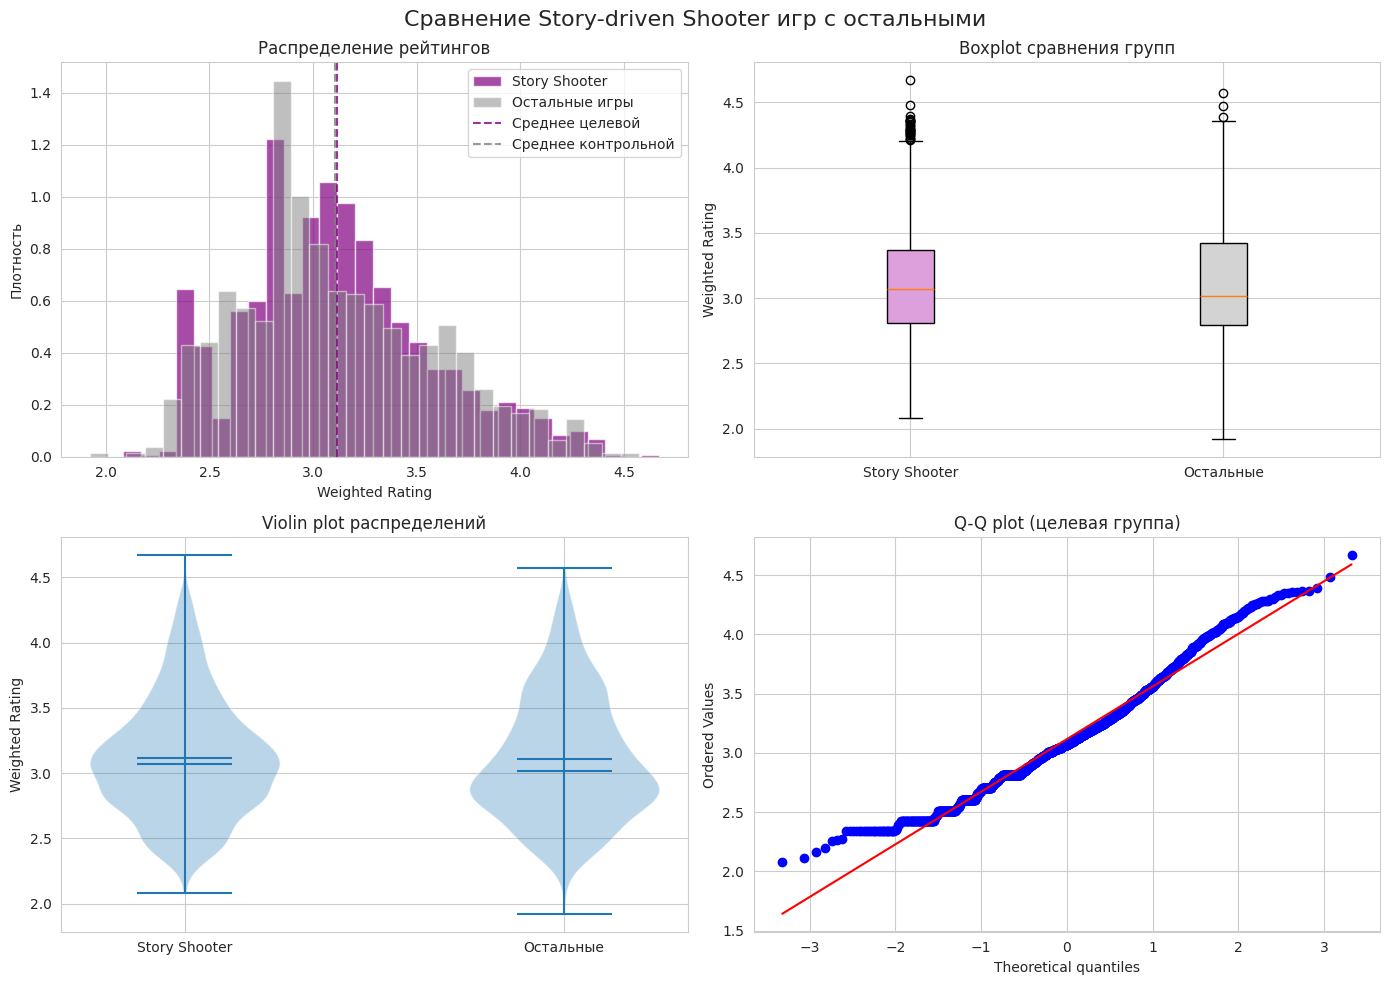

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Сравнение Story-driven Shooter игр с остальными', fontsize=16)


axes[0, 0].hist(group_target, bins=30, alpha=0.7,
                label='Story Shooter', color='purple', density=True)
axes[0, 0].hist(group_control, bins=30, alpha=0.5,
                label='Остальные игры', color='gray', density=True)
axes[0, 0].set_xlabel('Weighted Rating')
axes[0, 0].set_ylabel('Плотность')
axes[0, 0].set_title('Распределение рейтингов')
axes[0, 0].legend()
axes[0, 0].axvline(stats_target['mean'], color='purple',
                   linestyle='--', alpha=0.8, label='Среднее целевой')
axes[0, 0].axvline(stats_control['mean'], color='gray',
                   linestyle='--', alpha=0.8, label='Среднее контрольной')
axes[0, 0].legend()


boxplot_data = [group_target, group_control]
bp = axes[0, 1].boxplot(boxplot_data, labels=['Story Shooter', 'Остальные'], patch_artist=True)
colors = ['plum', 'lightgray']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[0, 1].set_ylabel('Weighted Rating')
axes[0, 1].set_title('Boxplot сравнения групп')


violin_parts = axes[1, 0].violinplot(boxplot_data, showmeans=True, showmedians=True)
axes[1, 0].set_xticks([1, 2])
axes[1, 0].set_xticklabels(['Story Shooter', 'Остальные'])
axes[1, 0].set_ylabel('Weighted Rating')
axes[1, 0].set_title('Violin plot распределений')


stats.probplot(group_target, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q plot (целевая группа)')

plt.tight_layout()
plt.show()

In [ ]:
def check_normality_shapiro(data, name, max_sample=5000):
    if len(data) > max_sample:
        data_sample = np.random.choice(data, size=max_sample, replace=False)
        stat, p = shapiro(data_sample)
        method = f"Shapiro-Wilk (на подвыборке {max_sample})"
    else:
        stat, p = shapiro(data)
        method = "Shapiro-Wilk"
    print(f"\n{name}:")
    print(f"  Метод: {method}")
    print(f"  Статистика: {stat:.4f}")
    print(f"  p-value: {p:.4f}")

    if p < 0.05:
        result = "НЕ нормальное"
        is_normal = False
    else:
        result = "нормальное"
        is_normal = True

    print(f"  Вывод: распределение {result} (α=0.05)")
    return {'stat': stat, 'p': p, 'is_normal': is_normal, 'method': method}

print("Тест Шапиро-Уилка на нормальность")
norm_target = check_normality_shapiro(group_target, "Целевая группа")
norm_control = check_normality_shapiro(group_control, "Контрольная группа")

Тест Шапиро-Уилка на нормальность

Целевая группа:
  Метод: Shapiro-Wilk
  Статистика: 0.9768
  p-value: 0.0000
  Вывод: распределение НЕ нормальное (α=0.05)

Контрольная группа:
  Метод: Shapiro-Wilk
  Статистика: 0.9704
  p-value: 0.0000
  Вывод: распределение НЕ нормальное (α=0.05)


In [ ]:
print("Тест Левина на равенство дисперсий")
stat_levene, p_levene = levene(group_target, group_control)
print(f"Статистика: {stat_levene:.4f}")
print(f"p-value: {p_levene:.4f}")

if p_levene < 0.05:
    print("Вывод: дисперсии НЕ равны (p < 0.05)")
    equal_var = False
else:
    print("Вывод: дисперсии равны (p ≥ 0.05)")
    equal_var = True

Тест Левина на равенство дисперсий
Статистика: 4.2430
p-value: 0.0395
Вывод: дисперсии НЕ равны (p < 0.05)


In [ ]:
stat, p = mannwhitneyu(group_target, group_control, alternative='greater')
test_type = "U-тест Манна-Уитни"

print(f"Метод сравнения: {test_type}")
print(f"  Статистика теста: {stat:.4f}")
print(f"  p-value: {p:.4f}")
print(f"  Уровень значимости α: 0.05")

Метод сравнения: U-тест Манна-Уитни
  Статистика теста: 690798.0000
  p-value: 0.1452
  Уровень значимости α: 0.05


Для концепта Singleplayer Shooter с фокусом на сюжет и постановку была проверена гипотеза о том, что такие игры получают более высокие пользовательские рейтинги по сравнению с остальными проектами. В целевую группу вошли 1 548 игр, в контрольную 870.

Средний рейтинг целевой группы составил 3.117, у контрольной группы 3.108. Абсолютная разница равна 0.009 пункта, что соответствует относительному преимуществу около 0.3 процента. Медианные значения также практически совпадают: 3.071 против 3.016. Разброс оценок сопоставим, коэффициент вариации равен 14.4 процента в целевой группе и 15.1 процента в контрольной.

Проверка нормальности распределений с помощью теста Шапиро–Уилка показала отклонение от нормального закона в обеих группах, поэтому для сравнения использовался U-тест Манна–Уитни. Его результат не выявил статистически значимых различий: p-value = 0.1452 при уровне значимости 0.05. Несмотря на различие дисперсий по тесту Левина (p-value = 0.0395), это не повлияло на итоговый вывод.

В результате гипотеза не подтверждается. Игры формата сюжетного одиночного шутера не демонстрируют статистически значимого и практически заметного преимущества по пользовательским рейтингам по сравнению с остальными играми.

# Средний weighted_rating различается хотя бы для одного жанра

Вариант 4: ANOVA - Сравнение рейтинга по популярным жанрам

Гипотезы:
- H₀: Средний weighted_rating одинаков для всех популярных жанров (Action, Adventure, RPG, Indie, Strategy)
- H₁: Средний weighted_rating различается хотя бы для одного жанра

Группы:
- Action (n=326)
- Adventure (n=385)
- RPG (n=56)
- Indie (n=865)
- Strategy (n=347)

In [ ]:
!pip install statsmodels

In [ ]:
!pip install statsmodels scikit-posthocs

In [ ]:
popular_genres = ['Action', 'Adventure', 'RPG', 'Indie', 'Strategy']
df_popular = df[df['main_genre'].isin(popular_genres)].copy()

action_data = df_popular[df_popular['main_genre'] == 'Action']['weighted_rating']
adventure_data = df_popular[df_popular['main_genre'] == 'Adventure']['weighted_rating']
rpg_data = df_popular[df_popular['main_genre'] == 'RPG']['weighted_rating']
indie_data = df_popular[df_popular['main_genre'] == 'Indie']['weighted_rating']
strategy_data = df_popular[df_popular['main_genre'] == 'Strategy']['weighted_rating']

groups_dict = {
    'Action': action_data,
    'Adventure': adventure_data,
    'RPG': rpg_data,
    'Indie': indie_data,
    'Strategy': strategy_data}

print("РАЗМЕРЫ ГРУПП ПО ЖАНРАМ:")
for genre, data in groups_dict.items():
    print(f"{genre:15}: {len(data):4} игр")

total_games = len(df_popular)
print(f"Общее количество игр в анализе: {total_games}")
print(f"Доля от общего датасета: {total_games/len(df)*100:.1f}%")

РАЗМЕРЫ ГРУПП ПО ЖАНРАМ:
Action         :  326 игр
Adventure      :  385 игр
RPG            :   56 игр
Indie          :  585 игр
Strategy       :  347 игр
Общее количество игр в анализе: 1699
Доля от общего датасета: 70.3%


In [ ]:
stats_table = []

for genre, data in groups_dict.items():
    n = len(data)
    mean_val = data.mean()
    median_val = data.median()
    std_val = data.std()
    min_val = data.min()
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    max_val = data.max()

    ci_low = mean_val - 1.96 * std_val / np.sqrt(n)
    ci_high = mean_val + 1.96 * std_val / np.sqrt(n)

    stats_table.append({
        'Жанр': genre,
        'n': n,
        'Среднее': mean_val,
        'Медиана': median_val,
        'Стд. откл.': std_val,
        'Минимум': min_val,
        '25%': q25,
        '75%': q75,
        'Максимум': max_val,
        'Дов. интервал (95%) низ': ci_low,
        'Дов. интервал (95%) верх': ci_high
    })

df_stats = pd.DataFrame(stats_table)
print("\nСтатистика weighted_rating по жанрам:")
print(df_stats.round(3).to_string(index=False))

genres_list = list(groups_dict.keys())
data_list = list(groups_dict.values())
means_list = [data.mean() for data in data_list]
stds_list = [data.std() for data in data_list]
ns_list = [len(data) for data in data_list]


Статистика weighted_rating по жанрам:
     Жанр   n  Среднее  Медиана  Стд. откл.  Минимум  25%   75%  Максимум  Дов. интервал (95%) низ  Дов. интервал (95%) верх
   Action 326    3.286    3.217       0.522    2.260 2.81 3.693     4.482                    3.229                     3.342
Adventure 385    3.166    3.113       0.482    2.109 2.81 3.481     4.669                    3.118                     3.215
      RPG  56    3.238    3.058       0.606    2.342 2.81 3.847     4.384                    3.079                     3.397
    Indie 585    3.085    3.060       0.409    1.922 2.81 3.322     4.357                    3.052                     3.118
 Strategy 347    3.125    3.080       0.434    2.310 2.81 3.350     4.322                    3.080                     3.171


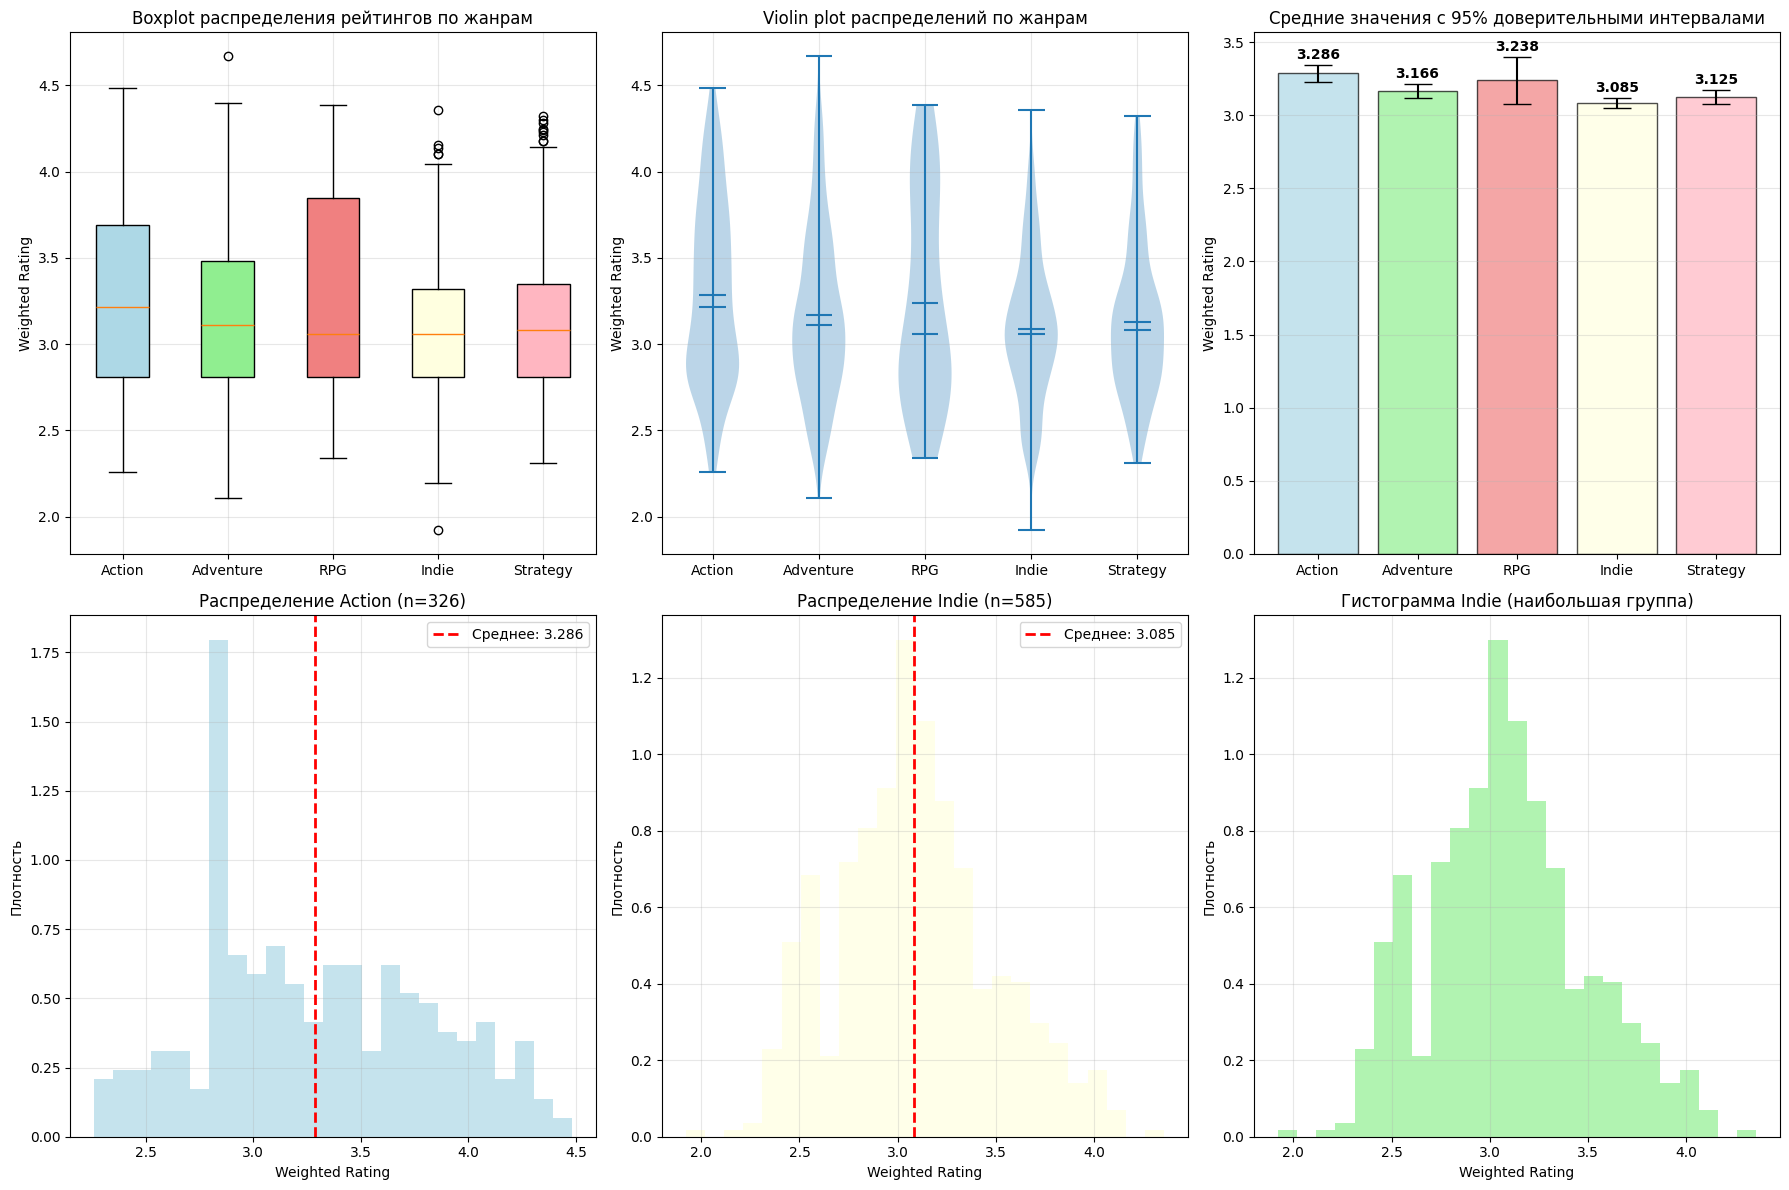

In [ ]:

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

box = axes[0, 0].boxplot(data_list, patch_artist=True, labels=genres_list)
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
axes[0, 0].set_ylabel('Weighted Rating')
axes[0, 0].set_title('Boxplot распределения рейтингов по жанрам')
axes[0, 0].grid(True, alpha=0.3)


from scipy.stats import gaussian_kde
violin_parts = axes[0, 1].violinplot(data_list, showmeans=True, showmedians=True)
axes[0, 1].set_xticks(range(1, len(genres_list) + 1))
axes[0, 1].set_xticklabels(genres_list)
axes[0, 1].set_ylabel('Weighted Rating')
axes[0, 1].set_title('Violin plot распределений по жанрам')
axes[0, 1].grid(True, alpha=0.3)


errors_list = [1.96 * std / np.sqrt(n) for std, n in zip(stds_list, ns_list)]
x_pos = np.arange(len(genres_list))
axes[0, 2].bar(x_pos, means_list, yerr=errors_list, capsize=10, color=colors, edgecolor='black', alpha=0.7)
axes[0, 2].set_xticks(x_pos)
axes[0, 2].set_xticklabels(genres_list)
axes[0, 2].set_ylabel('Weighted Rating')
axes[0, 2].set_title('Средние значения с 95% доверительными интервалами')
axes[0, 2].grid(True, alpha=0.3, axis='y')


for i, (mean_val, error_val) in enumerate(zip(means_list, errors_list)):
    axes[0, 2].text(i, mean_val + error_val + 0.02, f'{mean_val:.3f}',
                   ha='center', va='bottom', fontweight='bold')


if len(action_data) > 0:
    axes[1, 0].hist(action_data, bins=25, alpha=0.7, color='lightblue', density=True)
    axes[1, 0].axvline(means_list[0], color='red', linestyle='--', linewidth=2,
                      label=f'Среднее: {means_list[0]:.3f}')
    axes[1, 0].set_xlabel('Weighted Rating')
    axes[1, 0].set_ylabel('Плотность')
    axes[1, 0].set_title(f'Распределение Action (n={len(action_data)})')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)


if len(indie_data) > 0:
    axes[1, 1].hist(indie_data, bins=25, alpha=0.7, color='lightyellow', density=True)
    axes[1, 1].axvline(means_list[3], color='red', linestyle='--', linewidth=2,
                      label=f'Среднее: {means_list[3]:.3f}')
    axes[1, 1].set_xlabel('Weighted Rating')
    axes[1, 1].set_ylabel('Плотность')
    axes[1, 1].set_title(f'Распределение Indie (n={len(indie_data)})')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)


if len(indie_data) > 0:
    axes[1, 2].hist(indie_data, bins=25, alpha=0.7, color='lightgreen', density=True)
    axes[1, 2].set_xlabel('Weighted Rating')
    axes[1, 2].set_ylabel('Плотность')
    axes[1, 2].set_title(f'Гистограмма Indie (наибольшая группа)')
    axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
all_normal = True

for genre, data in groups_dict.items():
    if len(data) > 5000:
        data_sample = np.random.choice(data, size=5000, replace=False)
        stat, p_val = shapiro(data_sample)
        method = "Shapiro-Wilk (подвыборка 5000)"
    else:
        stat, p_val = shapiro(data)
        method = "Shapiro-Wilk"
    is_normal = p_val >= 0.05
    print(f"   {genre:15}: статистика={stat:.4f}, p-value={p_val:.4f}, "
          f"распределение {'нормальное' if is_normal else 'НЕ нормальное'}")
    if not is_normal:
        all_normal = False

print("\n   Тест Левина на равенство дисперсий:")
levene_stat, levene_p = levene(*data_list)
print(f"   Статистика: {levene_stat:.4f}, p-value: {levene_p:.4f}")

equal_variances = levene_p >= 0.05
print(f"   Вывод: дисперсии {'равны' if equal_variances else 'НЕ равны'}")

   Action         : статистика=0.9676, p-value=0.0000, распределение НЕ нормальное
   Adventure      : статистика=0.9737, p-value=0.0000, распределение НЕ нормальное
   RPG            : статистика=0.9204, p-value=0.0012, распределение НЕ нормальное
   Indie          : статистика=0.9886, p-value=0.0002, распределение НЕ нормальное
   Strategy       : статистика=0.9635, p-value=0.0000, распределение НЕ нормальное

   Тест Левина на равенство дисперсий:
   Статистика: 15.0654, p-value: 0.0000
   Вывод: дисперсии НЕ равны


In [ ]:
alpha = 0.05

from scipy.stats import kruskal
h_stat, p_value = kruskal(*data_list)

print(f"   H-статистика: {h_stat:.4f}")
print(f"   p-value: {p_value:.4f}")
print(f"   Уровень значимости α: {alpha}")

   H-статистика: 26.0799
   p-value: 0.0000
   Уровень значимости α: 0.05


In [ ]:
genres_data = {
    'Жанр': ['Action', 'Adventure', 'RPG', 'Indie', 'Strategy'],
    'n': [326, 385, 56, 585, 347],
    'Среднее': [3.286, 3.166, 3.238, 3.085, 3.125],
    'Медиана': [3.217, 3.113, 3.058, 3.060, 3.080],
    'Стд. откл.': [0.522, 0.482, 0.606, 0.409, 0.434],
    'Минимум': [2.260, 2.109, 2.342, 1.922, 2.310],
    '25%': [2.81, 2.81, 2.81, 2.81, 2.81],
    '75%': [3.693, 3.481, 3.847, 3.322, 3.350],
    'Максимум': [4.482, 4.669, 4.384, 4.357, 4.322]
}

df = pd.DataFrame(genres_data)

df['CV, %'] = (df['Стд. откл.'] / df['Среднее']) * 100

for idx, row in df.iterrows():
    print(f"{row['Жанр']} (n={row['n']}):")
    print(f"  Среднее: {row['Среднее']:.3f}")
    print(f"  Стд. откл.: {row['Стд. откл.']:.3f}")
    print(f"  CV = {row['Стд. откл.']:.3f}/{row['Среднее']:.3f} × 100% = {row['CV, %']:.2f}%")
    print()

print("=== СРАВНЕНИЕ КОЭФФИЦИЕНТОВ ВАРИАЦИИ ===")
print(f"Самый высокий CV: {df.loc[df['CV, %'].idxmax(), 'Жанр']} ({df['CV, %'].max():.2f}%)")
print(f"Самый низкий CV: {df.loc[df['CV, %'].idxmin(), 'Жанр']} ({df['CV, %'].min():.2f}%)")
print(f"Размах (разница между max и min): {df['CV, %'].max() - df['CV, %'].min():.2f}%")

print(f"\nСтатистика по CV:")
print(f"  Среднее CV: {df['CV, %'].mean():.2f}%")
print(f"  Медиана CV: {df['CV, %'].median():.2f}%")
print(f"  Стандартное отклонение CV: {df['CV, %'].std():.2f}%")

Action (n=326):
  Среднее: 3.286
  Стд. откл.: 0.522
  CV = 0.522/3.286 × 100% = 15.89%

Adventure (n=385):
  Среднее: 3.166
  Стд. откл.: 0.482
  CV = 0.482/3.166 × 100% = 15.22%

RPG (n=56):
  Среднее: 3.238
  Стд. откл.: 0.606
  CV = 0.606/3.238 × 100% = 18.72%

Indie (n=585):
  Среднее: 3.085
  Стд. откл.: 0.409
  CV = 0.409/3.085 × 100% = 13.26%

Strategy (n=347):
  Среднее: 3.125
  Стд. откл.: 0.434
  CV = 0.434/3.125 × 100% = 13.89%

=== СРАВНЕНИЕ КОЭФФИЦИЕНТОВ ВАРИАЦИИ ===
Самый высокий CV: RPG (18.72%)
Самый низкий CV: Indie (13.26%)
Размах (разница между max и min): 5.46%

Статистика по CV:
  Среднее CV: 15.39%
  Медиана CV: 15.22%
  Стандартное отклонение CV: 2.13%


Анализ рейтингов по жанрам показал, что популярные категории игр имеют заметные различия по среднему weighted_rating. Самый высокий средний рейтинг у Action - 3.286, чуть ниже RPG - 3.238, затем Adventure с 3.166, Strategy с 3.125 и Indie с самым низким средним - 3.085. Разброс оценок внутри жанров тоже разный: наибольшая вариативность у RPG (CV 18.72%), а у Indie она минимальная - 13.26%. Остальные жанры колеблются примерно между 15 и 16%.

Проверка на нормальность распределения показала, что ни один из жанров не соответствует нормальному распределению (p-value < 0.05), а тест Левена выявил, что дисперсии между жанрами не равны (p-value = 0.000). Это говорит о том, что средние рейтинги сравнивать напрямую через стандартную ANOVA рискованно, и результаты нужно интерпретировать с осторожностью.

Тем не менее, статистика H-теста дала значение 26.08 с p-value = 0.000, что однозначно указывает на различия хотя бы между двумя жанрами. Самые стабильные оценки у Indie (стд. отклонение 0.409), а самые разрозненные - у RPG (стд. отклонение 0.606).

В целом можно сказать, что жанр влияет на средний рейтинг игр: Action и RPG держатся выше, Indie и Strategy немного ниже. При этом разброс внутри жанров разный, поэтому для прогнозов или рекомендаций стоит учитывать не только средние значения, но и вариативность оценок.